# MvStudentT problem


In [1]:
# libraries
import numpy as NP
import pandas as PD
import pymc3 as PM
import theano.tensor as TT
import patsy as PA

import matplotlib.pyplot as PLT
import seaborn as SB
%matplotlib inline

seed = 42
NP.random.seed(seed)

%load_ext watermark


/usr/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%watermark -v -m -p numpy,pandas,theano,pymc3,patsy,matplotlib,seaborn

CPython 3.6.6
IPython 6.2.1

numpy 1.14.5
pandas 0.23.3
theano 1.0.2
pymc3 3.5.rc1
patsy 0.5.0
matplotlib 2.2.2
seaborn 0.8.1

compiler   : GCC 8.1.1 20180531
system     : Linux
release    : 4.17.5-1-ARCH
machine    : x86_64
processor  : 
CPU cores  : 8
interpreter: 64bit


## Data Generation

In [3]:
count = {}
actual = {}
label = {}

### covariates
# we assessed values of three covariates
# which are correlated
label['covariates'] = ['cov1', 'cov2', 'cov3']
count['covariates'] = len(label['covariates'])
actual['covariates_mean'] = NP.array([ 1, -1.8, 0.5 ])

# covariation within the covariates
actual['covariates_covariance_matrix'] = NP.array([ \
                                              [  1.1, -0.3,  0.1 ] \
                                            , [ -0.3,  0.8,  0.6 ] \
                                            , [  0.1,  0.6,  1.0 ] \
                                            ])



#_______________________________________________________________________________
### measurements
data = NP.random.multivariate_normal(  actual['covariates_mean'] \
                                           , actual['covariates_covariance_matrix'] \
                                           , size = 1000 \
                                          )
data = PD.DataFrame( data \
                , columns = label['covariates'] \
                )



## Model Construction

### Design Matrices

In [4]:

intercept_dmatrix = NP.asarray(PA.dmatrix( "1" \
                                        , data = data \
                                        , return_type = 'dataframe' \
                                        ))



### Model Definition

In [5]:
# the model
def GetBasicModel():
    with PM.Model() as model:

    ### intercept
        # (a) population level
        population_intercept = PM.Normal(  'population_intercept' \
                                         , mu = 0. \
                                         , sd = 1. \
                                         , shape = (intercept_dmatrix.shape[1], count['covariates']) \
                                        )


        # combine
        estimator = TT.dot(intercept_dmatrix, population_intercept)

    ### covariates
        # prior for covariates covariance
        packed_cholesky = PM.LKJCholeskyCov(  'packed_cholesky' \
                                            , n = count['covariates'] \
                                            , eta = 1. \
                                            , sd_dist = PM.HalfCauchy.dist(2.) \
                                            )

        # compute the covariates covariance and correlation matrix 
        cholesky_matrix = PM.expand_packed_triangular(count['covariates'], packed_cholesky, lower = True)

        # additional covariance diagnostics
        # could alternatively be recovered from the Cholesky matrix posterior
        # thus, remove for complex models
        covariance_matrix = PM.Deterministic('covariance_matrix' \
                                             , TT.dot(cholesky_matrix, cholesky_matrix.T) \
                                            )
        standard_deviations = PM.Deterministic('standard_deviations' \
                                             , TT.sqrt(TT.diag(covariance_matrix)) \
                                            )
        correlation_matrix = PM.Deterministic('correlation_matrix' \
                                            , TT.diag(standard_deviations**-1) \
                                                .dot(covariance_matrix.dot(TT.diag(standard_deviations**-1))) \
                                            )
        cross_correlation = PM.Deterministic('cross_correlation' \
                                             , correlation_matrix[NP.triu_indices(count['covariates'], k=1)] \
                                            )

        
    return model, estimator, cholesky_matrix, covariance_matrix


### model likelihood
model_chol, estimator, cholesky_matrix, covariance_matrix = GetBasicModel()
with model_chol:
    # This works:
    likelihood = PM.MvStudentT( 'likelihood' \
                            , mu = estimator \
                            , chol = cholesky_matrix \
                            , nu = 5. \
                            , observed = data.loc[:, label['covariates']].values \
                            )
    
model_cov, estimator, cholesky_matrix, covariance_matrix = GetBasicModel()
with model_cov:
    # # this does not work:
    likelihood = PM.MvStudentT( 'likelihood' \
                            , mu = estimator \
                            , cov = covariance_matrix \
                            , nu = 5. \
                            , observed = data.loc[:, label['covariates']].values \
                            )


### Sampling

In [6]:
sample_kwargs = dict ( \
                      n_steps = 2**10 \
                    , tune = 2**10 \
                    , random_seed = seed \
                    , cores = 4 \
                    , progressbar = True \
                     )

with model_cov:
    trace_cov = PM.sample( **sample_kwargs )
with model_chol:
    trace_chol = PM.sample( **sample_kwargs )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_cholesky, population_intercept]
Sampling 4 chains: 100%|██████████| 6096/6096 [00:11<00:00, 519.21draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_cholesky, population_intercept]
Sampling 4 chains: 100%|██████████| 6096/6096 [00:08<00:00, 752.58draws/s]


## Result

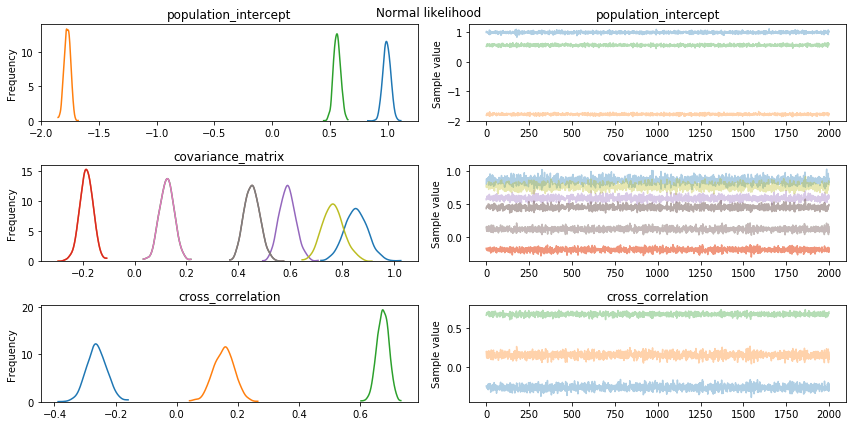

In [7]:
    
PM.traceplot( trace_cov \
            , combined = True \
            , varnames = [ 'population_intercept' \
                          ,'covariance_matrix' \
                          , 'cross_correlation' \
                         ] \
            
            )
PLT.gcf().suptitle('Normal likelihood')
PLT.show()



In [8]:
    
PM.traceplot( trace_chol \
            , combined = True \
            , varnames = [ 'population_intercept' \
                          ,'covariance_matrix' \
                          , 'cross_correlation' \
                         ] \
            
            )
PLT.gcf().suptitle("Student's T likelihood")
PLT.show()



**Question to developers:**
Why does the inference on cross_correlation get wrong with Student's T / robust design?